In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
print(X_footsteps_accelerations_absolute.shape)
print(Y_footsteps_accelerations_absolute.shape)

(17248, 31)
(17248, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where FR is swinging
idxs = np.where(X_footsteps_accelerations_absolute[:, -1] == 1)[0]
X_footsteps_accelerations_absolute_FR_swinging = X_footsteps_accelerations_absolute[idxs]
Y_footsteps_accelerations_absolute_FR_swinging = Y_footsteps_accelerations_absolute[idxs]

## Predict FR foot -> x

In [8]:
X_footsteps_accelerations_absolute_FR_swinging[0, :]

array([ 0.1       ,  0.        ,  0.        ,  0.1       ,  0.        ,
        0.        ,  0.09097511,  0.01569571,  0.03546102, -0.07442539,
        0.25578701,  0.13131595, -0.38037282,  0.22266933, -0.12780198,
       -0.381951  , -0.27515733,  0.12599015, -0.38960645, -0.2416217 ,
       -0.12631081, -0.38173601,  0.0753413 , -0.03407997, -0.01022839,
        0.09069058,  0.09356812, -0.00206157, -0.01183524,  0.        ,
        1.        ])

In [9]:
Y_footsteps_accelerations_absolute_FR_swinging[0, :]

array([ 0.06153266, -0.00069727,  0.06077899, -0.00427389])

### Linear Regression

In [10]:
def find_best_model(X, Y, runs=1000):
    best_model = None
    lowest_error = 100
    best_Xtr, best_Xte, best_Ytr, best_Yte = None, None, None, None
    
    for _ in range(runs):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.9, shuffle=True)
        
        model = LinearRegression()
        model.fit(X_train, Y_train)

        predictions = model.predict(X_test)
        error = np.max(np.abs(predictions - Y_test))

        if error < lowest_error:
            best_model = model
            lowest_error = error
            best_Xtr, best_Xte, best_Ytr, best_Yte = X_train, X_test, Y_train, Y_test

    # Stats
    predictions = best_model.predict(best_Xte)
    print('R2: ', r2_score(predictions, best_Yte))
    print('RMSE: ', np.sqrt(mean_squared_error(best_Yte, predictions)))
    print("The lowest error is: ", np.min(np.abs(predictions - best_Yte)))
    print("The highest error is: ", np.max(np.abs(predictions - best_Yte)))
    print("The avg. error is: ", np.mean(np.abs(predictions - best_Yte)))
    
    return best_Xte, best_Yte, predictions, best_model

In [11]:
# Input
X = np.hstack((X_footsteps_accelerations_absolute_FR_swinging[:, 0:1], # previous motion command
               X_footsteps_accelerations_absolute_FR_swinging[:, 3:4], # current motion command
               X_footsteps_accelerations_absolute_FR_swinging[:, -5:-4], # previous CoM velocity
               X_footsteps_accelerations_absolute_FR_swinging[:, 10:12], # FL (x,y) position
               X_footsteps_accelerations_absolute_FR_swinging[:, 13:15], # FR (x,y) position
               X_footsteps_accelerations_absolute_FR_swinging[:, 16:18], # RL (x,y) position
               X_footsteps_accelerations_absolute_FR_swinging[:, 19:21])) # RR (x,y) position

# Labels
Y = np.array([Y_footsteps_accelerations_absolute_FR_swinging[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split dataset and fit best model
X_test, Y_test, predictions, model_fr_relative_swinging_x = find_best_model(X, Y, runs=5000)

R2:  0.9981223460322802
RMSE:  0.00808539009657173
The lowest error is:  3.6661524452918925e-06
The highest error is:  0.02861430365424622
The avg. error is:  0.005941051356634367


In [12]:
model_fr_relative_swinging_x.coef_

array([[ 0.00550229,  0.02588771,  0.45332503,  0.02748123,  0.29243984,
        -1.1091232 , -0.02550018,  0.28212756,  0.13733254,  0.01814569,
        -0.06288233]])

In [13]:
model_fr_relative_swinging_x.intercept_

array([0.2684454])

In [40]:
inp = np.array([[0.9, 0.9, , 0.403, 0.094, -0.408, -0.09]])

In [41]:
out = model_fr_relative_swinging_x.coef_ @ inp.T
out += model_fr_relative_swinging_x.intercept_
print(out)

[[0.32947123]]


In [42]:
0.24888614 + out

array([[0.57835737]])

Text(0, 0.5, 'Predictions')

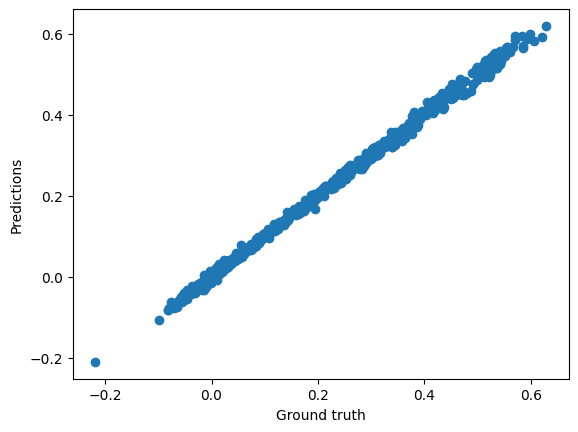

In [14]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [15]:
#for idx, prediction in enumerate(predictions):
#    print(f'{X_test[idx, 0]}->{X_test[idx, 1]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

### Predict FL foot -> y

In [16]:
# Input
X = np.hstack((X_footsteps_accelerations_absolute_FR_swinging[:, 0:1], # previous motion command
               X_footsteps_accelerations_absolute_FR_swinging[:, 3:4], # current motion command
               X_footsteps_accelerations_absolute_FR_swinging[:, -5:-4], # previous CoM velocity
               X_footsteps_accelerations_absolute_FR_swinging[:, 10:12], # FL (x,y) position
               X_footsteps_accelerations_absolute_FR_swinging[:, 13:15], # FR (x,y) position
               X_footsteps_accelerations_absolute_FR_swinging[:, 16:18], # RL (x,y) position
               X_footsteps_accelerations_absolute_FR_swinging[:, 19:21])) # RR (x,y) position

# Labels
Y = np.array([Y_footsteps_accelerations_absolute_FR_swinging[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split dataset and fit best model
X_test, Y_test, predictions, model_fr_relative_swinging_y = find_best_model(X, Y, runs=5000)

R2:  0.8896488316826074
RMSE:  0.00841524519749931
The lowest error is:  9.125130442627638e-06
The highest error is:  0.028036434143693847
The avg. error is:  0.006306970155518008


In [17]:
model_fr_relative_swinging_y.coef_

array([[-0.00963771,  0.01948639, -0.03714665, -0.50867355,  0.41008513,
        -0.44334668, -1.45220629,  0.42501618, -0.30823327,  0.65193678,
         0.46239365]])

In [18]:
model_fr_relative_swinging_y.intercept_

array([0.36585215])

Text(0, 0.5, 'Predictions')

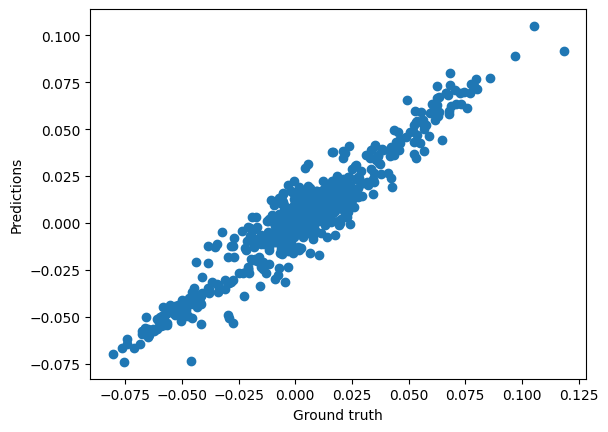

In [19]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [36]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')